# KDE Dataset Generation

The purpose of this project is to extract the essence of the dataset and generate a new dataset (bigger and/or smaller) from this.

We supposed that dataset essence is in the dataset distribution (attributes and categories). So we will estimate `PDFs` (`PDF` by category) from original dataset using `Kernel Density Estimation` and generate new datasets from them.

## Test Dataset

A test dataset will be necesarry to simplify the proposal analysis, development and testing.

The test dataset must have one attribute and 2 categories. Overlap between category distributions must be exist (just a little).

The test dataset will be generted with 300 instances, 150 instances per category.

Figure 1: Dataset distributions by category


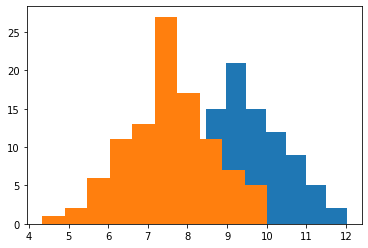

In [41]:
from kde_dataset_generator import dataset

# Dataset params
size = 200
n_categories = 2
seed = 8

# Generate df
df = dataset.generate_univariate_dataset(size, n_categories, seed)

# Plot df
print("Figure 1: Dataset distributions by category")
dataset.plot_univariate(df)


## Calculate KDEs by category

We needs to extract knowledge from dataset.

To achieve this, `PDFs` will be estimated for each category using `KDE`.

`KDE` is calculated by one category (values associated to a specific category) and all attributes.
This means that `KDE` will be multidimensional in multivariate datasets.

In [42]:
from kde_dataset_generator import kde 

# Caculate KDEs
kdes = kde.calculate_kdes(df)[0]

To make sure `PDFs` estimation are right, we will plot category distributions using the previous calculated `KDEs`.

Figure 2: Dataset distributions by category using KDEs based


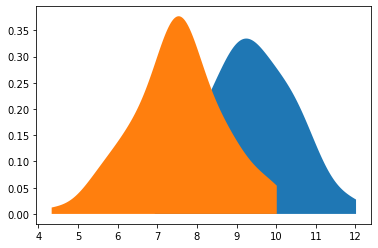

In [43]:
print("Figure 2: Dataset distributions by category using KDEs based")
kde.plot_univariate(df, kdes)

The distributions represented in charts are the same, so we concludes that `KDEs` are right.

## The theorical method

This method must generate a new dataset from original `KDEs`.

To achieve this, method will iterate for each category.

For an specific category, a support will be generated. This support will have instances that will be contained in category distribution space. Category distribution space are delimited by attribute ranges (min and max value) which means that every new instance attribute values must be contained in orignal attribute intervals.

New instances automatically will be labeled with the category from they are based on.

We will build a ranking by density which will be estimate for each instance using `KDE`.

Finally, we will prune this ranking using an specific threshold (density).

How to choose the optimal threshold for each dataset require an independant analysis. We will test some thresholds until get a similar distribution chart.

To simplify the analysis we will only focus on one category distribution. To build a new dataset this method must be apply for each category distribution (one per category).

We will plot category distribution in which we have focused.

Figure 3: Filtered dataset distribution (1 attribute and category


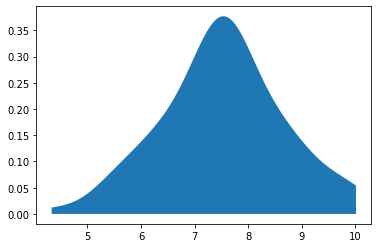

In [44]:
# Get dataset with only values associated to category 0
filtered_df = df[df.iloc[:,-1] == 0]

# Get filtered dataset KDEs
filtered_kdes, filtered_ranges = kde.calculate_kdes(filtered_df)

# Plot dataset distribution
print("Figure 3: Filtered dataset distribution (1 attribute and category") 
kde.plot_univariate(filtered_df, filtered_kdes)

We will need to generate a properly support.

This support must meet the following requesites:
- Instances must be contain in dataset space.
- There must be a significant number of instances which are relevant to original dataset.

A several of methods of support generation can be designed. This methods must generate support with previous requesites.

To test this proposal theorically, we are going to use an exahustive method which will generate an equally spaced support over all dataset space.

The granularity grade of this support can be regulated increasing or decreasing the number of instances which make up the support.

The optimal granularity grade depends of each dataset and would be an independant study to achieve it. We are going to use a granularity grade which allows to generate a support with enough number of relevant instances.

If we want to extrapolate this method to multivariate dataset, new instances will be build from a cartesian product between all attribute supports. 

The exahustive method is useful for this stage (analysis and development) but it will be useless in practice because the method complexity is exponential which means that inifinite time will be needed to execute this method on relative small datasets. So it will be important to design an efficient method to generate the support.

We will generate the support for our dataset with one attribute and one category.

In [45]:
import numpy as np

# Get min value of the range
min_value = filtered_df.iloc[:,0].min()
# Get max value of the range
max_value = filtered_df.iloc[:,0].max()
# Define granularity
granularity = 1000
# Generate support
support = np.linspace(min_value, max_value, granularity)

This support will be our new dataset which looks like this.

Figure 4: Raw new kde distribution


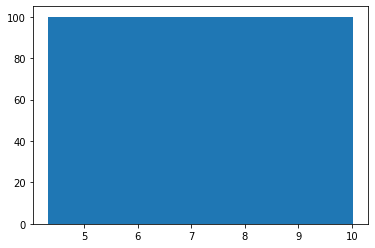

In [46]:
import pandas as pd

# Define new dataset
new_df = pd.DataFrame(dict(x=support, category=np.full(granularity,0)))

# Plot new dataset
print("Figure 4: Raw new kde distribution")
dataset.plot_univariate(new_df)


The new dataset distribution is shaped like a rectangle and does not look like the original.

We will use the `KDE` of the original distribution to reshape this rectangle until getting the correct shape.

We will reshape the support making a ranking by density (calculating the density for each support value using the original `KDE`) and pruning this ranking by a specific threshold.

As a first step we will estimate densities for each instance.

In [47]:
# Calculate densities for each instance
densities = kde.estimate_density(new_df, filtered_kdes)

We will build a density ranking sorting (descendant) new dataset instances by density.

In [48]:
# Build ranking from new df
ranking = kde.build_ranking(densities)


We will prune the ranking using a specify threshold getting the final distribution. The threshold value represents the amount of instances which will take from to top to build the final dataset.

In [49]:
# Define threshold
threshold = 100
# Prune the ranking
prune_df = kde.prune(ranking, threshold)
# Add instances from prune_df to original df
new_df = new_df.append(prune_df, ignore_index=True)

/tmp/ipykernel_19859/1238975863.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(prune_df, ignore_index=True)


Now we have a new dataset. We will need to test the dataset distribution.

To test the dataset distribution we are going to plot dataset distribution and compare the chart with original dataset distribution.


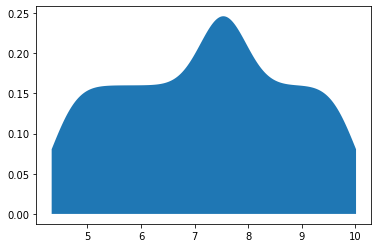

In [50]:
# Plot new df
new_kdes = kde.calculate_kdes(new_df)[0]
kde.plot_univariate(new_df, new_kdes)